### Synchrony value값이 제대로 뽑힌 것이 맞는가? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import os
from tqdm import tqdm

C:\Users\user\AppData\Local\Temp\ipykernel_2852\334042515.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def directional_agreement(signal1, signal2):
    # Normalize the signals
    signal1_norm = (signal1 - np.mean(signal1)) / np.std(signal1)
    signal2_norm = (signal2 - np.mean(signal2)) / np.std(signal2)
    
    # Compute the dot product
    dot_product = np.dot(signal1_norm, signal2_norm)
    
    # Compute the directional agreement
    directional_agreement = dot_product / len(signal1)
    
    return directional_agreement

# 로우패스 필터 설계
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def cross_correlation(signal1, signal2):
    # Time lag range (-len(signal1)+1, len(signal1)-1)
    time_lags = np.arange(-len(signal1) + 1, len(signal1))
    # Compute cross-correlation for each time lag
    cross_corr = [np.correlate(signal1, np.roll(signal2, shift), mode='valid')[0] for shift in time_lags]
    
    return np.array(cross_corr), time_lags

# 1은 완벽한 양의 상관관계를 나타냄. -1은 음의 상관 관계를 나타냄. 0은 상관관계가 없음. 

def pearson_cross_correlation(signal1, signal2):
    # Subtract the mean
    signal1_mean = np.mean(signal1)
    signal2_mean = np.mean(signal2)
    
    signal1_adjusted = signal1 - signal1_mean
    signal2_adjusted = signal2 - signal2_mean
    
    # Calculate Pearson correlation coefficient
    numerator = np.sum(signal1_adjusted * signal2_adjusted)
    denominator = np.sqrt(np.sum(signal1_adjusted ** 2) * np.sum(signal2_adjusted ** 2))
    
    pearson_corr = numerator / denominator
    
    return pearson_corr

def rolling_window_correlation(signal1, signal2, window_size):
    num_samples = len(signal1)
    correlations = []

    for i in tqdm(range(num_samples - window_size + 1), desc="Calculating Rolling Window Correlation"):
        window1 = signal1[i : i + window_size]
        window2 = signal2[i : i + window_size]
        
        # Calculate Pearson correlation coefficient for the current window
        correlation = np.corrcoef(window1, window2)[0, 1]
        correlations.append(correlation)

    return np.array(correlations)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def zscore_signal(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    
    # Avoid division by zero
    if signal_std == 0:
        signal_normalized = np.zeros_like(signal)
        #print(signal_normalized)
    else:
        signal_normalized = (signal - signal_mean) / signal_std
        #print(signal_normalized)
    
    # # Subtract the mean and divide by the standard deviation
    # signal_normalized = (signal - signal_mean) / signal_std
    
    return signal_normalized

1          NaN
2     00:13:02
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8     00:27:04
9          NaN
10    00:27:44
11         NaN
Name: 고개 위아래 끄덕임 (2명), dtype: object
0    782
1    424
2    464
Name: 고개 위아래 끄덕임 (2명), dtype: int64
0    385
1    395
Name: 고개 위아래 끄덕임 (3명), dtype: int64


Calculating Rolling Window Correlation: 100%|██████████| 28476/28476 [00:00<00:00, 44707.47it/s]


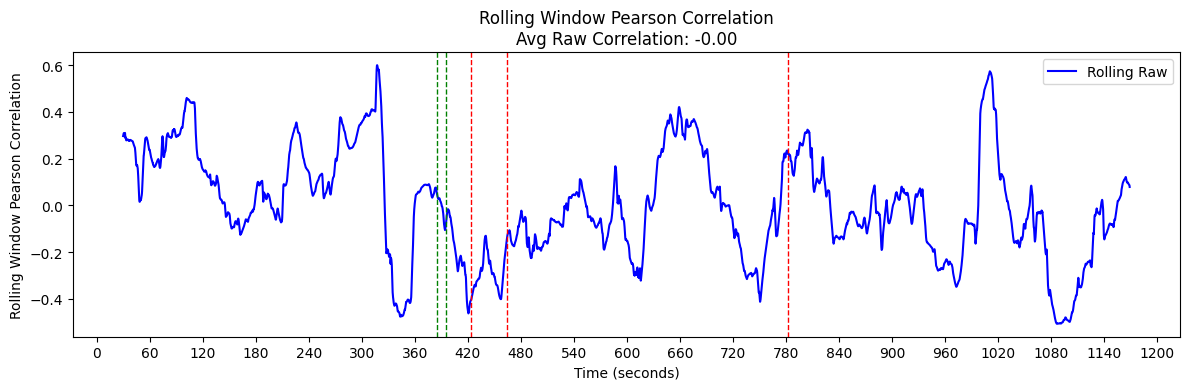

In [31]:
# Load data from CSV files || 입력받으려는 데이터의 경우, Head Rotation 의 (x,y,z 값과 각 축의 변화량 값, lip_distance 값)이 있는 것. 
# 얼굴 움직임 값을 계산하기 위해서 불러오기 위한 코드 부분. 

# Load the uploaded Excel file
file_path = 'C:/Users/user/Desktop/Group_Lean_time_2.xlsx'
xls = pd.ExcelFile(file_path)

# Load the 'A_group' sheet into a DataFrame
a_group_df = pd.read_excel(file_path, sheet_name='A_group_2W_S1')

# Extracting the time information from the relevant column
time_data = a_group_df['고개 위아래 끄덕임 (2명)'][1:]  # Skipping the first two rows which are headers
print(time_data)
# NaN 값이 있는 구간은 없애주기.
time_data = time_data.dropna()
#print(time_data)
time_data = time_data.astype(str)

# Converting time data to seconds
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    # 시간, 분, 초 
    total_seconds = h * 3600 + m * 60 + s
    
    #return h * 3600 + m * 60 + s
    # 전체 시간에서 20분을 뻄. 
    if total_seconds > 1200:  # Only subtract 20 minutes if total time is more than 20 minutes
        adjusted_seconds = total_seconds - 1200
    else:
        adjusted_seconds = total_seconds
    return adjusted_seconds

group_times_seconds_adjusted = time_data.apply(time_to_seconds).reset_index(drop=True)
#group_times_seconds = time_data.apply(time_to_seconds).reset_index(drop=True)
print(group_times_seconds_adjusted)


# Extracting the time information from the '고개 위아래 끄덕임 (3명)' column
time_data_s2_3 = a_group_df['고개 위아래 끄덕임 (3명)'][1:]  # Skipping the first two rows which are headers
time_data_s2_3 = time_data_s2_3.dropna()
time_data_s2_3 = time_data_s2_3.astype(str)

# Converting time data to seconds and subtracting 20 minutes for '고개 위아래 끄덕임 (3명)'
group_times_seconds_adjusted_3 = time_data_s2_3.apply(time_to_seconds).reset_index(drop=True)
print(group_times_seconds_adjusted_3)

csv_files = [
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_2W_A1_S1.csv',
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_2W_A2_S1.csv',
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_2W_A3_S1.csv',
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_2W_A4_S1.csv',
]

# Group time 시간을 자동으로 동그라미 칠 수 있도록 불러올 것. 
'''

To do list) 
1. 그룹 시간을 저장한 파일 가져오기. 
2. 가져온 파일 안에서의 시간 정보를 바탕으로, Correlation 그래프에 표시하도록 할 것. 

'''

data_xlse = []
valid_files = True
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        # Check if the dataframe is empty or all values are NaN
        if df.empty: # or df.isnull().all().all()
            print(f"File {file} is empty. Skipping this set.")
            valid_files = False
            break
        data_xlse.append(df)
    else:
        print(f"File {file} does not exist. Skipping this set.")
        valid_files = False
        break

if valid_files:
    # Load data and extract the column of interest
    data_xlse = [pd.read_csv(file) for file in csv_files]
    data = [df['X'] for df in data_xlse] # X , Y, Z, Delta_X, Delta_Y, Delta_Z 

    # Define frame rate and time window
    frame_rate = 25  # frames per second
    start_time = 0  # in seconds
    end_time =  1199 # in seconds

    start_frame = start_time * frame_rate
    end_frame = end_time * frame_rate

    #start_frame = 0
    #end_frame = 1200

    # 샘플 신호 생성
    fs = frame_rate  # 샘플링 주파수 (Hz)
    num_samples = end_frame - start_frame
    t = np.linspace(start_time, end_time, num_samples, endpoint=False)


    # 로우패스 필터 적용
    cutoff = 0.5  # 커트오프 주파수 (Hz)

    '''
    # Specify the bandpass filter parameters
    lowcut = 0.1  # Low cutoff frequency in Hz
    highcut = 0.5  # High cutoff frequency in Hz
    fs = 25  # Sampling frequency in Hz
    order = 5  # Filter order
    '''

    # 머리 움직임 값.
    signal1_raw = data[0][start_frame:end_frame].to_numpy()
    signal2_raw = data[1][start_frame:end_frame].to_numpy()

    signal1_raw = zscore_signal(signal1_raw)
    signal2_raw = zscore_signal(signal2_raw)

    # Extract data within the specified window
    signal1 = lowpass_filter(signal1_raw, cutoff, fs) # 변경 전= signal1_raw, cutoff, fs
    signal2 = lowpass_filter(signal2_raw, cutoff, fs) # 변경 전, signal2_raw, cutoff, fs

    signal1 = zscore_signal(signal1)
    signal2 = zscore_signal(signal2)
    
    # Directional Agreement를 계산합니다.
    #da_score = directional_agreement(signal1, signal2)

    # Cross Correlation 계산
    #cross_corr_values, time_lags = cross_correlation(signal1, signal2)

    # Calculate Pearson correlation coefficients for raw and filtered signals at each time lag
    #cross_corr_values_raw, time_lags_raw = cross_correlation(signal1_raw, signal2_raw)
    #cross_corr_values_filtered, time_lags_filtered = cross_correlation(signal1, signal2)

    # Calculate rolling window correlation
    window_size = 60 * frame_rate
    rolling_correlations_raw = rolling_window_correlation(signal1_raw, signal2_raw, window_size)
    #rolling_correlations_filtered = rolling_window_correlation(signal1, signal2, window_size)
    
    # Generate the time index for rolling correlations
    rolling_time_index = np.arange(len(rolling_correlations_raw))

    # Convert frame indices to time in seconds
    time_seconds = np.linspace(start_time, end_time, len(signal1_raw))
    
    # Plot additional Rolling Window Correlation alongside existing plots
    plt.figure(figsize=(12, 10))

    # Plot 1: Signals (Raw and Filtered)
    #plt.subplot(3, 1, 1)
    #plt.plot(time_seconds,signal1_raw, label='Signal 1 Raw', color='blue')
    #plt.plot(time_seconds,signal2_raw, label='Signal 2 Raw', color='orange')
    #plt.plot(time_seconds,signal1, label='Signal 1 Filtered', color='green')
    #plt.plot(time_seconds,signal2, label='Signal 2 Filtered', color='red')
    #plt.xlabel('Time (seconds)')
    #plt.ylabel('Amplitude')
    #plt.title('Raw and Filtered Signals')
    #plt.legend()

    avg_rolling_correlation_raw = np.mean(rolling_correlations_raw)
    #avg_rolling_correlation_filtered = np.mean(rolling_correlations_filtered)

    # Plot 2: Rolling Window Correlation with average values in the title
    plt.subplot(3, 1, 2)
    plt.plot(time_seconds[window_size // 2:len(rolling_correlations_raw) + window_size // 2], rolling_correlations_raw, label='Rolling Raw', color='blue')
    #plt.plot(time_seconds[window_size // 2:len(rolling_correlations_filtered) + window_size // 2], rolling_correlations_filtered, label='Rolling Filtered', color='green')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Rolling Window Pearson Correlation')
    #plt.ylim(-1.0, 1.0)
    plt.title(f'Rolling Window Pearson Correlation\nAvg Raw Correlation: {avg_rolling_correlation_raw:.2f}') # \nAvg Filtered Correlation: {avg_rolling_correlation_filtered:.2f}'
    max_time = max(time_seconds)
    x_ticks = range(0, int(max_time) + 60, 60)
    plt.xticks(x_ticks)
    plt.legend()

    # Plotting group times as circles
    # for gt in group_times_seconds:
    #     plt.axvline(x=gt, color='red', linestyle='--', linewidth=1, label='Group Time' if gt == group_times_seconds.iloc[0] else "")
        
    for gt in group_times_seconds_adjusted:
        plt.axvline(x=gt, color='red', linestyle='--', linewidth=1, label='2명 Group Time' if gt == group_times_seconds_adjusted.iloc[0] else "")

    for gt in group_times_seconds_adjusted_3:
         plt.axvline(x=gt, color='green', linestyle='--', linewidth=1, label='3명 Group Time' if gt == group_times_seconds_adjusted_3.iloc[0] else "")
    

    plt.tight_layout()
    #plt.show()
    img_path = 'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/Synchrony_Plot/'
    plt.savefig(img_path + f'A_group_2W_S1.png')
else:
    print("Vaild data files not found. Processing skipped")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import os
from tqdm import tqdm

In [ ]:
def directional_agreement(signal1, signal2):
    # Normalize the signals
    signal1_norm = (signal1 - np.mean(signal1)) / np.std(signal1)
    signal2_norm = (signal2 - np.mean(signal2)) / np.std(signal2)
    
    # Compute the dot product
    dot_product = np.dot(signal1_norm, signal2_norm)
    
    # Compute the directional agreement
    directional_agreement = dot_product / len(signal1)
    
    return directional_agreement

# 로우패스 필터 설계
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def cross_correlation(signal1, signal2):
    # Time lag range (-len(signal1)+1, len(signal1)-1)
    time_lags = np.arange(-len(signal1) + 1, len(signal1))
    # Compute cross-correlation for each time lag
    cross_corr = [np.correlate(signal1, np.roll(signal2, shift), mode='valid')[0] for shift in time_lags]
    
    return np.array(cross_corr), time_lags

def pearson_cross_correlation(signal1, signal2):
    # Subtract the mean
    signal1_mean = np.mean(signal1)
    signal2_mean = np.mean(signal2)
    
    signal1_adjusted = signal1 - signal1_mean
    signal2_adjusted = signal2 - signal2_mean
    
    # Calculate Pearson correlation coefficient
    numerator = np.sum(signal1_adjusted * signal2_adjusted)
    denominator = np.sqrt(np.sum(signal1_adjusted ** 2) * np.sum(signal2_adjusted ** 2))
    
    pearson_corr = numerator / denominator
    
    return pearson_corr

def rolling_window_correlation(signal1, signal2, window_size):
    num_samples = len(signal1)
    correlations = []

    for i in tqdm(range(num_samples - window_size + 1), desc="Calculating Rolling Window Correlation"):
        window1 = signal1[i : i + window_size]
        window2 = signal2[i : i + window_size]
        
        correlation = np.corrcoef(window1, window2)[0, 1]
        correlations.append(correlation)

    return np.array(correlations)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def zscore_signal(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    
    if signal_std == 0:
        signal_normalized = np.zeros_like(signal)
    else:
        signal_normalized = (signal - signal_mean) / signal_std
    
    return signal_normalized

# Load data from CSV files
csv_files = [
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_1W_A1_S2.csv',
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_1W_A2_S2.csv',
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_1W_A3_S2.csv',
    f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/A_group/Face_1W_A4_S2.csv',
]

data_xlse = []
valid_files = True
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        # Check if the dataframe is empty or all values are NaN
        if df.empty:
            print(f"File {file} is empty. Skipping this set.")
            valid_files = False
            break
        data_xlse.append(df)
    else:
        print(f"File {file} does not exist. Skipping this set.")
        valid_files = False
        break

if valid_files:
    data_xlse = [pd.read_csv(file) for file in csv_files]
    data = [df['X'] for df in data_xlse]  # X , Y, Z, Delta_X, Delta_Y, Delta_Z 

    frame_rate = 25  # frames per second
    start_time = 0  # in seconds
    end_time =  1199 # in seconds

    start_frame = start_time * frame_rate
    end_frame = end_time * frame_rate

    fs = frame_rate  # 샘플링 주파수 (Hz)
    num_samples = end_frame - start_frame
    t = np.linspace(start_time, end_time, num_samples, endpoint=False)

    signal1_raw = data[0][start_frame:end_frame].to_numpy()
    signal2_raw = data[1][start_frame:end_frame].to_numpy()

    signal1_raw = zscore_signal(signal1_raw)
    signal2_raw = zscore_signal(signal2_raw)

    # 주파수 대역 필터링 적용
    lowcut = 0.1  # Low cutoff frequency in Hz
    highcut = 3.0  # High cutoff frequency in Hz

    signal1 = bandpass_filter(signal1_raw, lowcut, highcut, fs)
    signal2 = bandpass_filter(signal2_raw, lowcut, highcut, fs)

    signal1 = zscore_signal(signal1)
    signal2 = zscore_signal(signal2)

    window_size = 60 * frame_rate
    rolling_correlations_raw = rolling_window_correlation(signal1_raw, signal2_raw, window_size)
    rolling_correlations_filtered = rolling_window_correlation(signal1, signal2, window_size)
    #print(np.mean(rolling_correlations_filtered))


    rolling_time_index = np.arange(len(rolling_correlations_raw))
    time_seconds = np.linspace(start_time, end_time, len(signal1_raw))

    # 신호의 피크를 감지하여 rolling window correlation plot에 선을 긋기
    peak_threshold = 0.4  # 피크 임계값 설정
    peak_indices = np.where(rolling_correlations_filtered > peak_threshold)[0]
    #print(peak_indices)

    plt.figure(figsize=(12, 10))

    # Plot 1: Signals (Raw and Filtered)
    plt.subplot(3, 1, 1)
    plt.plot(time_seconds, signal1_raw, label='Signal 1 Raw', color='blue')
    plt.plot(time_seconds, signal2_raw, label='Signal 2 Raw', color='orange')
    plt.plot(time_seconds, signal1, label='Signal 1 Filtered', color='green')
    plt.plot(time_seconds, signal2, label='Signal 2 Filtered', color='red')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Raw and Filtered Signals')
    plt.legend()

    avg_rolling_correlation_raw = np.mean(rolling_correlations_raw)
    avg_rolling_correlation_filtered = np.mean(rolling_correlations_filtered)

    # Plot 2: Rolling Window Correlation with average values in the title
    plt.subplot(3, 1, 2)
    plt.plot(time_seconds[window_size // 2:len(rolling_correlations_raw) + window_size // 2], rolling_correlations_raw, label='Rolling Raw', color='blue')
    plt.plot(time_seconds[window_size // 2:len(rolling_correlations_filtered) + window_size // 2], rolling_correlations_filtered, label='Rolling Filtered', color='green')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Rolling Window Pearson Correlation')
    plt.title(f'Rolling Window Pearson Correlation\nAvg Raw Correlation: {avg_rolling_correlation_raw:.2f}\nAvg Filtered Correlation: {avg_rolling_correlation_filtered:.2f}')
    max_time = max(time_seconds)
    x_ticks = range(0, int(max_time) + 60, 60)
    plt.xticks(x_ticks)
    plt.legend()

    # 피크 구간에 선 그리기
    for peak_idx in peak_indices:
        peak_time = time_seconds[window_size // 2 + peak_idx]
        plt.axvline(x=peak_time, color='purple', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()
    #img_path = 'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/PC and RC plot/B/'
    #plt.savefig(img_path + 'B_group_PC and RC_1W_S2.png')
else:
    print("Vaild data files not found. Processing skipped")

### Corrleation 값을 추출하는 코드

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
def rolling_window_correlation(signal1, signal2, window_size):
    num_samples = len(signal1)
    correlations = []
    
    for i in range(num_samples - window_size + 1):
        window1 = signal1[i : i + window_size]
        window2 = signal2[i : i + window_size]
        
        # Calculate Pearson correlation coefficient for the current window
        correlation = np.corrcoef(window1, window2)[0, 1]
        correlations.append(correlation)
    
    return np.array(correlations)

def zscore_signal(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    
     # Avoid division by zero
    if signal_std == 0:
        signal_normalized = np.zeros_like(signal)
    else:
        signal_normalized = (signal - signal_mean) / signal_std
    
    return signal_normalized
    
    # # Subtract the mean and divide by the standard deviation
    # signal_normalized = (signal - signal_mean) / signal_std
    
    # return signal_normalized
    
def truncate_signals(signal1, signal2):
    min_length = min(len(signal1), len(signal2))
    return signal1[:min_length], signal2[:min_length]

In [ ]:
group_name = ['A','B','C','D','E','F','G']  
weeks = ['1W','2W', '3W', '4W']
section_num = ['S1','S2'] 

# Load data from CSV files
total_path = 'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/face_Synchrony/total_synchrony(delta).csv'
total_synchrony = pd.DataFrame()

for group in tqdm(group_name, desc = "Groups"): # desc: 진행 바 앞에 문자열을 출력하기 위해 쓰는 키워드 
    for week in tqdm(weeks, desc=f"Weeks for group {group}"):
        for section in tqdm(section_num, desc=f"section for week {week}"):
            csv_files = [
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}1_{section}.csv',
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}2_{section}.csv',
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}3_{section}.csv',
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}4_{section}.csv'
            ]
            
            data_xlse = [] 
            vaild_files = True # 파일 안에 데이터가 있는지 없는지
            for file in csv_files:
                if os.path.exists(file): # csv_files[0]
                    df = pd.read_csv(file)
                    if df.empty:
                        print(f"File {file} is empty. Skip this set")
                        vaild_files = False
                    data_xlse.append(df)
                else:
                    print(f"File {file} does not exist. Skip this set")
                    vaild_files = False
                    break
                
            if vaild_files:
                # 길이가 맞지 않는 데이터의 경우 넘어갈 수 있도록 설정. 
                lengths = [len(df) for df in data_xlse]
                #print(lengths)
                if len(set(lengths)) != 1:
                    print(f"Files for group {group}, week {week}, section {section} have different lengths. Skipping this set.")
                    continue
                # 추출하고 싶은 데이터 값을 넣어 둠. 
                data_xlse = [pd.read_csv(file) for file in csv_files]
                
                # 머리 움직임 값을 계산해서, 저장하고 싶은데 어떻게 해야할까? 
                data = [np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2) for df in data_xlse] # X, Y, Z, Delta_X, Delta_Y, Delta_Z, Lip_Distance
                #data = [np.sqrt(df['Delta_X']**2 + df['Delta_Y']**2 + df['Delta_Z']**2) for df in data_xlse] 
                
                frame_rate = 25
                data_frame_section = pd.DataFrame() # 네 개의 신호 간 모든 쌍에 대해 상관 관계를 계산하여 section_means 값에 저장. 
                section_means = []
                
                for i in range(4):
                    for j in range(i+1, 4):
                        signal1 = np.array(data[i]) # 머리 움직임에서의 값...
                        #print("signal1 : ", signal1)
                        signal2 = np.array(data[j])
                        #print("signal2 : ", signal2)
                        
                        signal1, signal2 = truncate_signals(signal1, signal2)
                        
                        signal1 = zscore_signal(signal1)
                        signal2 = zscore_signal(signal2)
                        
                        window_size = 60 * frame_rate
                        corr_data = rolling_window_correlation(signal1, signal2, window_size)
                        section_means.append(np.mean(corr_data))
                        col_name = f"{i}_{j}"
                        data_frame_section[col_name] = corr_data
                
                total_synchrony[f'{group}_{week}_{section}'] = section_means
                excel_path = f'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/face_Synchrony/face_movement/Face_{week}_{group}_{section}_movement_Synchrony.csv'
                data_frame_section.to_csv(excel_path, index=False)

total_synchrony.to_csv(total_path, index=False)

### 몸의 sync 값을 출력하는 부분

In [ ]:
group_name = ['A','B','C','D','E','F','G']  
weeks = ['1W','2W', '3W', '4W']
section_num = ['S1','S2'] 

# Load data from CSV files
total_path = 'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/face_Synchrony/total_body_synchrony.csv'
total_synchrony = pd.DataFrame()

for group in tqdm(group_name, desc = "Groups"): # desc: 진행 바 앞에 문자열을 출력하기 위해 쓰는 키워드 
    for week in tqdm(weeks, desc=f"Weeks for group {group}"):
        for section in tqdm(section_num, desc=f"section for week {week}"):
            csv_files = [
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}1_{section}.csv',
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}2_{section}.csv',
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}3_{section}.csv',
                f'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/{group}_group_delta/Face_{week}_{group}4_{section}.csv'
            ]
            
            data_xlse = [] 
            vaild_files = True # 파일 안에 데이터가 있는지 없는지
            for file in csv_files:
                if os.path.exists(file): # csv_files[0]
                    df = pd.read_csv(file)
                    if df.empty:
                        print(f"File {file} is empty. Skip this set")
                        vaild_files = False
                    data_xlse.append(df)
                else:
                    print(f"File {file} does not exist. Skip this set")
                    vaild_files = False
                    break
                
            if vaild_files:
                # 길이가 맞지 않는 데이터의 경우 넘어갈 수 있도록 설정. 
                lengths = [len(df) for df in data_xlse]
                #print(lengths)
                if len(set(lengths)) != 1:
                    print(f"Files for group {group}, week {week}, section {section} have different lengths. Skipping this set.")
                    continue
                # 추출하고 싶은 데이터 값을 넣어 둠. 
                data_xlse = [pd.read_csv(file) for file in csv_files]
                
                # 머리 움직임 값을 계산해서, 저장하고 싶은데 어떻게 해야할까? 
                data = [np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2) for df in data_xlse] # X, Y, Z, Delta_X, Delta_Y, Delta_Z, Lip_Distance
                #data = [np.sqrt(df['Delta_X']**2 + df['Delta_Y']**2 + df['Delta_Z']**2) for df in data_xlse] 
                
                frame_rate = 25
                data_frame_section = pd.DataFrame() # 네 개의 신호 간 모든 쌍에 대해 상관 관계를 계산하여 section_means 값에 저장. 
                section_means = []
                
                for i in range(4):
                    for j in range(i+1, 4):
                        signal1 = np.array(data[i]) # 머리 움직임에서의 값...
                        #print("signal1 : ", signal1)
                        signal2 = np.array(data[j])
                        #print("signal2 : ", signal2)
                        
                        signal1, signal2 = truncate_signals(signal1, signal2)
                        
                        signal1 = zscore_signal(signal1)
                        signal2 = zscore_signal(signal2)
                        
                        window_size = 60 * frame_rate
                        corr_data = rolling_window_correlation(signal1, signal2, window_size)
                        section_means.append(np.mean(corr_data))
                        col_name = f"{i}_{j}"
                        data_frame_section[col_name] = corr_data
                
                total_synchrony[f'{group}_{week}_{section}'] = section_means
                excel_path = f'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/face_Synchrony/face_movement/Face_{week}_{group}_{section}_movement_Synchrony.csv'
                data_frame_section.to_csv(excel_path, index=False)

total_synchrony.to_csv(total_path, index=False)

### 파일이 섞여서 저장이 되었으므로, 이를 분류하여 따로 저장할 수 있는 코드

In [ ]:
import os
import shutil

# 현재 파일들이 섞여 있는 폴더 경로와 이동할 폴더 경로 설정
current_folder = 'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/face_Synchrony/Save_File_delta/'
destination_folder = 'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/face_Synchrony/face_movement/'

# Temp_folder가 존재하지 않으면 생성
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# 현재 폴더 내 파일들을 확인하고 이동
for filename in os.listdir(current_folder):
    if 'movement_Synchrony' in filename:
        # 이동할 파일의 전체 경로 생성
        src_file_path = os.path.join(current_folder, filename)
        dest_file_path = os.path.join(destination_folder, filename)
        
        # 파일 이동
        shutil.move(src_file_path, dest_file_path)
        print(f"Moved: {filename}")

print("Files have been moved successfully.")

### Synchrony 값이 저장된 파일을 불러오고, 주차 별로 평균내는 코드

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
# 경로에 존재하는 파일 읽어오기. 
Weeks = ['1W', '2W', '3W', '4W']
Steps = ['S1', 'S2']
groups = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

path = 'D:/MultiModal/MultiModal_Model/Head_Rotation_Mouse/face_Synchrony/face_movement/'

#그룹 별 평균 값을 저장하기 위한 딕셔너리 선언 
group_means = {group: {week: [] for week in Weeks} for group in groups}

for group in groups:
    for week in Weeks:
        for step in Steps:
            # Set the directory path
            directory_path = os.path.join(path)
            
            # Get the list of files in the directory
            if os.path.exists(directory_path):
                file_list = os.listdir(directory_path)
                
                for file_name in file_list:
                    # Check if the file name contains the specific week, group, and step
                    if f'Face_{week}_{group}_{step}_movement_Synchrony' in file_name:
                        # Set the file path
                        file_path = os.path.join(directory_path, file_name)
                        read_test = pd.read_csv(file_path)
                        
                        #print('Each column names in csv : ', read_test.columns)
                        
                        # 각 신호의 평균 값을 저장하기 위한 곳. 
                        columns_of_interest = ['0_1', '0_2', '0_3', '1_2', '1_3', '2_3']
                        col_means = read_test[columns_of_interest].mean(axis=0).mean()
                        
                        #print(f"Current {week}_{group}_{step} mean : ", col_means)
                        
                        group_means[group][week].append(col_means)
                        #rint('Current group means : ', group_means )

# #NaN 값이 있을 시, 평균 값이 계산되지 않으므로, nan 부분이 있다면 넘어갈 수 있도록 세팅.
weekly_means = {group: {week: np.nanmean(values) if len(values) > 0 else np.nan for week, values in group_means[group].items()} for group in groups}

weekly_means_df = pd.DataFrame(weekly_means).T
# 그룹의 상관관계가 있는 값을 가지고, 보는 것.
output_path = 'D:/MultiModal/Data/Data_PreProcessing/Head_Rotation_Mouse/group_weekly_synchrony_means.xlsx'
weekly_means_df.to_excel(output_path)
print(weekly_means_df)